## Clustering, Forecasting, and Detecting Outliers in COVID-19 Confirmed Cases

On January 22, 2020, King County, Washington, reported the first confirmed case of coronavirus disease 2019 (COVID-19) in the United States. Since then, several waves of outbreaks have surged across the country. Given the extreme risk to public health, local health departments collect detailed information on the number of confirmed cases, hospitalizations, and recovery rates.  Using these data, we can explore, using ArcGIS Notebook, how the disease spreads in both space and time and potentially forecast its future pattern.

In [18]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
# show plots after Notebook cells
%matplotlib inline 

### Step 1: Download CSV and explore your data 
Use the CSV files (known cases, deaths, population for US counties) downloaded from the <a href="https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/" target="_blank">USAFacts</a> website. It’s a not-for-profit provider of policy, economic and demographic data, and the COVID-19 confirmed cases and death are updated daily.

Alternatively, there are many other different data source for COVID-19. You can use API to call the data from the <a href="https://github.com/nytimes/covid-19-data" target="_blank">New York Times COVID-19 data repository or use the JHU dashboard data stored on our <a href="https://coronavirus-disasterresponse.hub.arcgis.com/" target="_blank">COVID-19 GIS Hub</a>. Choose the one that you feel the most comfortable with and start from there. I choose using USAFacts data since the county-level population data is also available there and I’m not only interested in the total cases, but also the per 100K cases, so I need the population data as well.

In [19]:
arcpy.env.overwriteOutput = True
workGDB = arcpy.env.workspace
workGDB

'C:\\demo\\DevSummit2021-TimeSeriesAnalysis\\DevSummit2021-TimeSeriesAnalysis.gdb'

In [20]:
# Point workFolder to the COVID-19 subfolder in the project
# Download the latest data to the workFolder
# Resources from USAFacts: https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/

workFolder = os.path.join(os.path.dirname(workGDB), "COVID-19")
workFolder

'C:\\demo\\DevSummit2021-TimeSeriesAnalysis\\COVID-19'

In [21]:
# Read in CSV files using Pandas
# KNOWN CASES
confirmed = pd.read_csv(os.path.join(workFolder, "covid_confirmed_usafacts.csv"), low_memory = False) 
# DEATH
death = pd.read_csv(os.path.join(workFolder, "covid_deaths_usafacts.csv"), low_memory = False) 
# COUNTY POPULATIONS
population = pd.read_csv(os.path.join(workFolder, "covid_county_population_usafacts.csv"), low_memory = False)  

In [5]:
# Explore the data structures of confirmed cases
confirmed.head()

countyFIPS            County Name State  ...  1/24/21  1/25/21  1/26/21
0           0  Statewide Unallocated    AL  ...        0        0        0
1        1001         Autauga County    AL  ...     5376     5407     5440
2        1003         Baldwin County    AL  ...    17256    17333    17496
3        1005         Barbour County    AL  ...     1827     1834     1882
4        1007            Bibb County    AL  ...     2223     2229     2247

[5 rows x 375 columns]

In [6]:
# Check the time span of the data
# firstDate = confirmed.columns[-1] 
lastDate = confirmed.columns[-1] 
date = pd.to_datetime(lastDate, format = '%m/%d/%y').strftime('%m%d')
print(f"The data starts from 1/22/20 and up to {lastDate}")

The data starts from 1/22/20 and up to 1/26/21


In [7]:
# Check out the top 5 counties with largest number of death related to COVID-19 up to date
death.sort_values(by = lastDate).tail()

countyFIPS         County Name State  ...  1/24/21  1/25/21  1/26/21
107         4013     Maricopa County    AZ  ...     6950     6951     7053
1903       36081       Queens County    NY  ...     7979     7996     8013
1886       36047        Kings County    NY  ...     8205     8230     8246
625        17031         Cook County    IL  ...     8706     8724     8734
211         6037  Los Angeles County    CA  ...    15162    15260    15303

[5 rows x 375 columns]

In [8]:
# Check out county population dataframe as well using counties in California
# We should notice the Grand Princess Cruise Ship is included but population is 0. 
# Be careful to avoid zero-division error when calculate per 100K data
population.loc[population["State"] == "CA"].head()

countyFIPS                 County Name State  population
191           0       Statewide Unallocated    CA           0
192        6000  Grand Princess Cruise Ship    CA           0
193        6001              Alameda County    CA     1671329
194        6003               Alpine County    CA        1129
195        6005               Amador County    CA       39752

### Step 2: Data cleaning and convert cumulative data to daily new cases or deaths


In [51]:
# Remove rows with NaN and 0 (Statewide Unallocated) in countyFIPS
if confirmed['countyFIPS'].isnull().values.any():
    confirmed = confirmed.dropna(subset=['countyFIPS'])
if death['countyFIPS'].isnull().values.any():
    death = death.dropna(subset=['countyFIPS'])
if population['countyFIPS'].isnull().values.any():
    population = population.dropna(subset=['countyFIPS'])

confirmed = confirmed.loc[confirmed['countyFIPS'] != 0]
death = death.loc[death['countyFIPS'] != 0]
population = population.loc[population['countyFIPS'] != 0]

In [52]:
# Stack the table for cumulative Confirmed Cases
confirmed = confirmed.set_index(['countyFIPS'])
confirmed = confirmed.drop(columns=['State', 'County Name', 'stateFIPS'])
confirmed_stacked = confirmed.stack()
confirmed_stacked_df = pd.DataFrame(confirmed_stacked)
confirmed_csv = os.path.join(workFolder, "confirmed.csv")
confirmed_stacked_df.to_csv(confirmed_csv)
confirmed_stacked_df = pd.read_csv(confirmed_csv)
confirmed_stacked_df.columns = ['countyFIPS', "DateTime", "ConfirmedCases"]
confirmed_stacked_df

countyFIPS DateTime  ConfirmedCases
0              1001  1/22/20               0
1              1001  1/23/20               0
2              1001  1/24/20               0
3              1001  1/25/20               0
4              1001  1/26/20               0
...             ...      ...             ...
1166790       56045  1/22/21             609
1166791       56045  1/23/21             609
1166792       56045  1/24/21             609
1166793       56045  1/25/21             609
1166794       56045  1/26/21             609

[1166795 rows x 3 columns]

In [53]:
# Stack the table for cumulative Deaths
death = death.set_index(['countyFIPS'])
death = death.drop(columns=['State', 'County Name', 'stateFIPS'])
death_stacked = death.stack()
death_stacked_df = pd.DataFrame(death_stacked)
death_csv = os.path.join(workFolder, "death.csv")
death_stacked_df.to_csv(death_csv)
death_stacked_df = pd.read_csv(death_csv)
death_stacked_df.columns = ['countyFIPS', "DateTime", "Deaths"]
death_stacked_df

countyFIPS DateTime  Deaths
0              1001  1/22/20       0
1              1001  1/23/20       0
2              1001  1/24/20       0
3              1001  1/25/20       0
4              1001  1/26/20       0
...             ...      ...     ...
1166790       56045  1/22/21       4
1166791       56045  1/23/21       4
1166792       56045  1/24/21       4
1166793       56045  1/25/21       4
1166794       56045  1/26/21       4

[1166795 rows x 3 columns]

In [56]:
# Join the two dataframes, set countyFIPS as index
numbers = death_stacked_df["Deaths"]
confirmed_and_death = confirmed_stacked_df.join(numbers)

In [68]:
# Merge population data
result = pd.merge(confirmed_and_death, population, how='left', on=['countyFIPS'])

In [57]:
# Convert datetime field
# Tips: using format = '%m/%d/%y' will be much faster than infer_datetime_format=True or saying nothing about format
result['DateTime'] =  pd.to_datetime(result['DateTime'], format = format = '%m/%d/%y')
result.tail()

countyFIPS   DateTime  ConfirmedCases  Deaths
1166790       56045 2021-01-22             609       4
1166791       56045 2021-01-23             609       4
1166792       56045 2021-01-24             609       4
1166793       56045 2021-01-25             609       4
1166794       56045 2021-01-26             609       4

In [70]:
# As mentioned before, to avoid zero division error, check if there is any location with population is nan or 0
# If so, remove those rows from the dataframe
df = result.loc[(result['population'].isnull()) | (result['population'] == 0) ]
removeFIPS = df.countyFIPS.unique()
if len(removeFIPS):
    result = result.loc[-result['countyFIPS'].isin(removeFIPS)]
    print(f"remove {len(removeFIPS)} counties with nan or 0 population: {removeFIPS}")

# 1 = New York City Unallocated/Probable, populatuon no information, no covid-19 cases
# 2270 = Wade Hampton Census Area, population = 0, no covid-19 cases
# 6000 = Grand Princess Cruise Ship, not a location, populaton = 0, 21 confirmed covid-19 cases

remove 3 counties with nan or 0 population: [2270 6000    1]


In [79]:
# Calculate daily new cases and deaths by .diff()
# https://pandas.pydata.org/pandas-docs/version/0.23.1/generated/pandas.DataFrame.diff.html
cols = ['ConfirmedCases', 'Deaths']
daily = result[cols].diff()

# Rename the columns as the daily data
dailyCols = [f"DailyNew{x}" for x in cols]
daily.columns = dailyCols
daily

DailyNewConfirmedCases  DailyNewDeaths
0                           NaN             NaN
1                           0.0             0.0
2                           0.0             0.0
3                           0.0             0.0
4                           0.0             0.0
...                         ...             ...
1166790                     0.0             0.0
1166791                     0.0             0.0
1166792                     0.0             0.0
1166793                     0.0             0.0
1166794                     0.0             0.0

[1165682 rows x 2 columns]

In [80]:
# Join the two new columns back to the origial dataframe
confirmed_and_death_cum_and_daily = result.join(daily)

In [84]:
# Fix corner cases in the data
## Replace the value for the first date 01/22/2020 (NaN after .diff) to be the same with 01/22/2020
## Also replace any negative daily new case or death to be 0
## Reference: https://stackoverflow.com/questions/47953338/how-to-replace-values-of-selected-row-of-a-column-in-pandas-dataframe
confirmed_and_death_cum_and_daily.loc[confirmed_and_death_cum_and_daily['DateTime'] == '2020-01-22', 'DailyNewConfirmedCases'] = confirmed_and_death_cum_and_daily['ConfirmedCases']
confirmed_and_death_cum_and_daily.loc[confirmed_and_death_cum_and_daily['DailyNewConfirmedCases'] < 0, 'DailyNewConfirmedCases'] = 0
confirmed_and_death_cum_and_daily.loc[confirmed_and_death_cum_and_daily['DateTime'] == '2020-01-22', 'DailyNewDeaths'] = confirmed_and_death_cum_and_daily['Deaths']
confirmed_and_death_cum_and_daily.loc[confirmed_and_death_cum_and_daily['DailyNewDeaths'] < 0, 'DailyNewDeaths'] = 0

In [89]:
# Check out the data for Los Anegeles County, California
LA = confirmed_and_death_cum_and_daily.loc[confirmed_and_death_cum_and_daily["County Name"] == "Los Angeles County"]
LA

countyFIPS   DateTime  ...  DailyNewConfirmedCases  DailyNewDeaths
76426        6037 2020-01-22  ...                     0.0             0.0
76427        6037 2020-01-23  ...                     0.0             0.0
76428        6037 2020-01-24  ...                     0.0             0.0
76429        6037 2020-01-25  ...                     0.0             0.0
76430        6037 2020-01-26  ...                     1.0             0.0
...           ...        ...  ...                     ...             ...
76792        6037 2021-01-22  ...                  7447.0           257.0
76793        6037 2021-01-23  ...                  8122.0           253.0
76794        6037 2021-01-24  ...                  9784.0           268.0
76795        6037 2021-01-25  ...                  7796.0            98.0
76796        6037 2021-01-26  ...                  6424.0            43.0

[371 rows x 9 columns]

### Step 3: Calculate Moving Average for daily new confirmed cases & daily new deaths
To account for the lack of reporting on weekends in many places, a seven-day average of daily new cases is commonly used in many COVID-19 dashboards or reports. We will follow this common practice and remove the first six days of the original data since they don't have enough data to calcuate their 7-day average. So our final data starts from 1/28/2020.

#### Let's create some quick bar plots of the daily new data in Los Angelos County, California

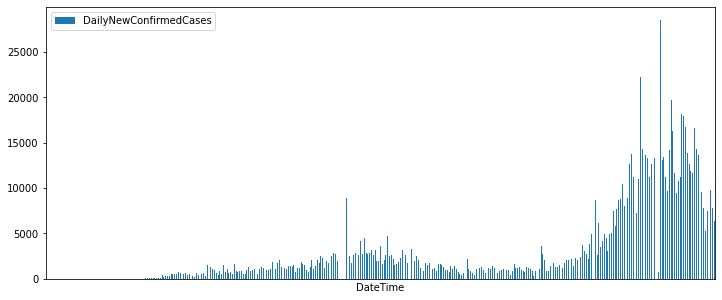

In [106]:
# Create a quick plot of Daily New Confirmed Cases in LA
ax = LA.plot.bar(x='DateTime', y='DailyNewConfirmedCases', rot= 0, figsize = (12,5))

# Remove xticks
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.show()

# References: 
# [Remove xticks] https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot
# [Configure plot size] https://stackoverflow.com/questions/51174691/how-to-increase-image-size-of-pandas-dataframe-plot-in-jupyter-notebook/51174822

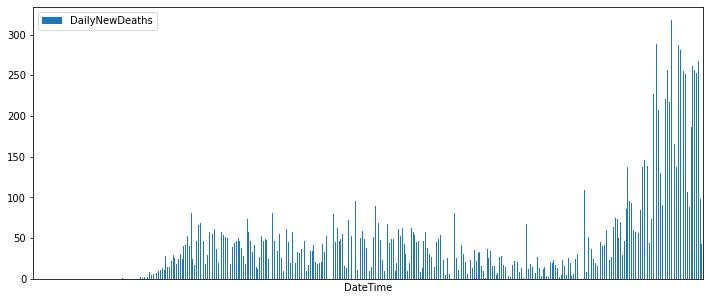

In [108]:
# Create another quick plot of the Daily New Death in LA
ax = LA.plot.bar(x='DateTime', y='DailyNewDeaths', rot= 0, figsize = (12,5))

# Remove xticks
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.show()

#### We can see some artificial weekly patterns in both daily data, so caculate 7-day average is necessary

In [107]:
# Calculate 7-day Simple Moving Average
# (takes around 2 minutes)
# Reference: https://www.datacamp.com/community/tutorials/moving-averages-in-pandas

# Set moving average window = 7 days
SMA_Window = 7

# Copy the dataframe
df = confirmed_and_death_cum_and_daily

# Do calculation
for fips in df.countyFIPS.unique():
    for name in dailyCols:
        field = f'{name}_{SMA_Window}DayAverage'
        column_index = df.columns.get_loc(name)
        df.loc[df['countyFIPS'] == fips, field] = df.loc[df['countyFIPS'] == fips].iloc[:, column_index].rolling(window=SMA_Window).mean()  

In [25]:
# Round the moving average fields
movingAverageCols = [f'{name}_{SMA_Window}DayAverage' for name in dailyCols]
for name in movingAverageCols:
    df[name] = round(df[name])
df.tail()

countyFIPS  ...  DailyNewDeaths_7DayAverage
1116470       56045  ...                         0.0
1116471       56045  ...                         0.0
1116472       56045  ...                         0.0
1116473       56045  ...                         0.0
1116474       56045  ...                         0.0

[5 rows x 11 columns]

In [ ]:
df.head(10)

#### Also need to cut off the first 6 days since the first moving average value starts from 7th day

In [111]:
firstMADay = df['DateTime'].iloc[0] + pd.DateOffset(days=SMA_Window-1)
firstMADay

Timestamp('2020-01-28 00:00:00')

In [114]:
df_fromFirstMADay = df.loc[df['DateTime'] >= firstMADay]

### Step 4: Calculate per 100K residents data 
- Cumulative Confirmed Cases per 100K
- Cumulative Deaths per 100K
- Daily new confired cases per 100K
- Daily new death per 100K
- 7-day moving average of Daily new confired cases per 100K
- 7-day moving average of Daily new death per 100K 

In [116]:
# Disable the SettingWithCopy warning 
# Reference: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None 

# Calculate the per 100K data and round 
originalCols = ['ConfirmedCases', 'Deaths', 'DailyNewConfirmedCases', 'DailyNewDeaths', 'DailyNewConfirmedCases_7DayAverage', 'DailyNewDeaths_7DayAverage']
for column in originalCols:
    newColumn = f'{column}_per100K'
    df_fromFirstMADay[newColumn] = round(df_fromFirstMADay[column] / df_fromFirstMADay['population'] * 100000)

In [118]:
df_fromFirstMADay.tail()

countyFIPS  ... DailyNewDeaths_7DayAverage_per100K
1166790       56045  ...                                0.0
1166791       56045  ...                                0.0
1166792       56045  ...                                0.0
1166793       56045  ...                                0.0
1166794       56045  ...                                0.0

[5 rows x 17 columns]

In [128]:
# Convert all numeric columns to int
per100KCols = [f'{column}_per100K' for column in originalCols]
cols = originalCols + per100KCols + ['population']
df_copy = df_fromFirstMADay.copy()
df_copy[cols] = df_copy[cols].applymap(np.int32)
df_copy.dtypes

countyFIPS                                             int64
DateTime                                      datetime64[ns]
ConfirmedCases                                         int64
Deaths                                                 int64
County Name                                           object
State                                                 object
population                                             int64
DailyNewConfirmedCases                                 int64
DailyNewDeaths                                         int64
DailyNewConfirmedCases_7DayAverage                     int64
DailyNewDeaths_7DayAverage                             int64
ConfirmedCases_per100K                                 int64
Deaths_per100K                                         int64
DailyNewConfirmedCases_per100K                         int64
DailyNewDeaths_per100K                                 int64
DailyNewConfirmedCases_7DayAverage_per100K             int64
DailyNewDeaths_7DayAvera

In [129]:
# Export pandas dataframe to CSV
MA_csv = os.path.join(workFolder, f"confirmed_and_death_{date}.csv")
df_copy.to_csv(MA_csv)
MA_csv

'C:\\demo\\DevSummit2021-TimeSeriesAnalysis\\COVID-19\\confirmedCased_deaths_0126.csv'

### Step 5: More matplotlib plots... checkout the difference: raw data vs 7-day average

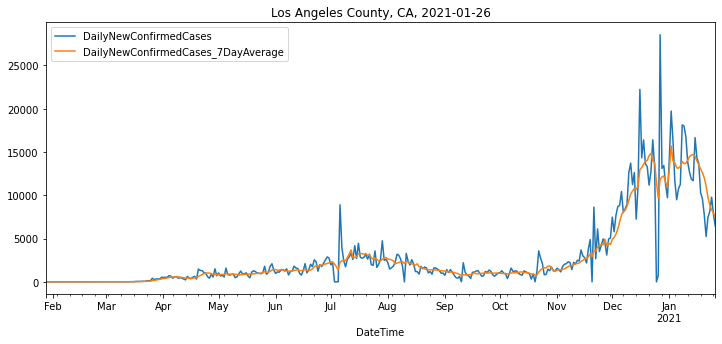

In [130]:
# Check moving average result for LA county - Daily new confirmed cases
FIPS = 6037 # LA
# FIPS = 36061 # Manhattan
# FIPS = 53033 # King County, WA
# FIPS = 2060 # Bristol Bay Borough, Alaska
# FIPS = 2282 # Yakutat  Borough, Alaska
# FIPS = 15005 # Kalawao County in Hawaii
df = df_fromFirstMADay
currentDate = max(df['DateTime']).strftime("%Y-%m-%d")
countyName = df.loc[df['countyFIPS'] == FIPS, 'County Name'].iloc[0]
stateName = df.loc[df['countyFIPS'] == FIPS, 'State'].iloc[0]
plotTitle = f"{countyName}, {stateName}, {currentDate}"

df_LA = df.loc[df['countyFIPS'] == FIPS][['DateTime','DailyNewConfirmedCases', f'DailyNewConfirmedCases_{SMA_Window}DayAverage']]
df_LA = df_LA.set_index('DateTime')
lines = df_LA.plot.line(figsize = (12,5), title = plotTitle)
plt.show()

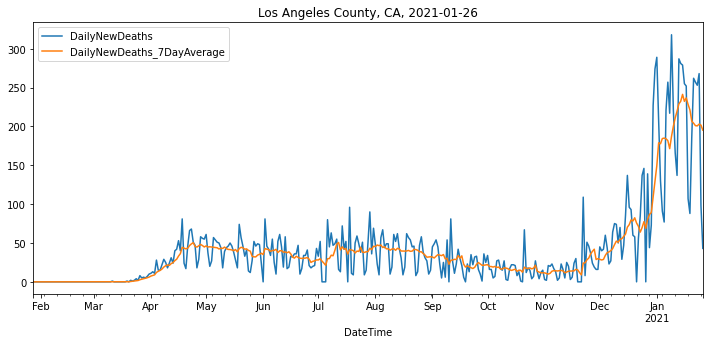

In [131]:
# Check moving average result for LA county - daily new death
df_LA = df.loc[df['countyFIPS'] == FIPS][['DateTime','DailyNewDeaths', f'DailyNewDeaths_{SMA_Window}DayAverage']]
df_LA = df_LA.set_index('DateTime')
lines = df_LA.plot.line(figsize = (12,5), title = plotTitle)
plt.show()

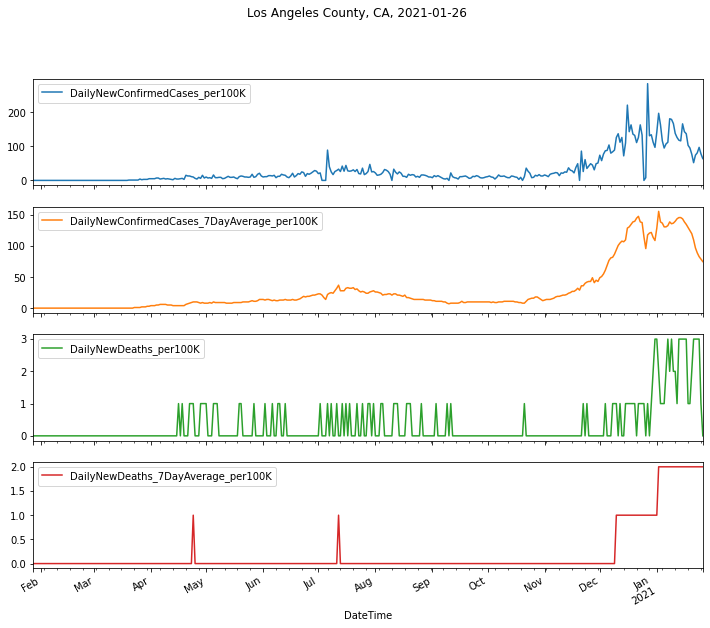

In [133]:
# Check per 100K residents data vs. per 100K 7-day average data
df_LA = df.loc[df['countyFIPS'] == FIPS][['DateTime','DailyNewConfirmedCases_per100K', f'DailyNewConfirmedCases_{SMA_Window}DayAverage_per100K', 'DailyNewDeaths_per100K', f'DailyNewDeaths_{SMA_Window}DayAverage_per100K']]
df_LA = df_LA.set_index('DateTime')
df_LA.plot(subplots=True, figsize=(12, 10), title = plotTitle)
plt.legend(loc='best')
plt.show()

### Step 6: Create Space Time Cube using Defined Locations with ArcPy
- Not only the daily new cases, but we can also do temporal aggregation, ex. weekly new cases
- Also we can create cubes containing subset of data: 
    - cube for one state, ex. California
    - cube for a certain time period, ex. 7/1/2020 - 12/31/2020.

In [138]:
def createCubeFromCSV_withMA(csvWithPath, workFolder, daily = True, weekly = False, monthly = False):
    ### Function to create cube with 7-day moving average & per 100K residents ###
    ### Also can aggregate daily data to weekly and monthly (30-day actually) ###
    csv = os.path.basename(csvWithPath)
    tb = csv.split(".")[0]
    # output cube = use the same name with CSV, will be saved at workFolder
    outputCube = os.path.join(workFolder, tb + ".nc")
    
    # template feature = US counties polygons
    gdb = workGDB
    templateFC = os.path.join(gdb, "us_counties_for_COVID19")
    # Convert csv to a table in data.gdb
    arcpy.conversion.TableToTable(csvWithPath, gdb, tb)
    tbName = os.path.join(gdb, tb)
    
    if daily:
        # Create Space Time Cube From Defined Locations - daily
        arcpy.stpm.CreateSpaceTimeCubeDefinedLocations(templateFC, outputCube, "NFIPS", "NO_TEMPORAL_AGGREGATION", "DateTime", "1 Days", "END_TIME", None, "ConfirmedCases DROP_LOCATIONS;Deaths DROP_LOCATIONS;DailyNewConfirmedCases DROP_LOCATIONS;DailyNewDeaths DROP_LOCATIONS;DailyNewConfirmedCases_7DayAverage DROP_LOCATIONS;DailyNewDeaths_7DayAverage DROP_LOCATIONS;ConfirmedCases_per100K DROP_LOCATIONS;Deaths_per100K DROP_LOCATIONS;DailyNewConfirmedCases_per100K DROP_LOCATIONS;DailyNewDeaths_per100K DROP_LOCATIONS;DailyNewConfirmedCases_7DayAverage_per100K DROP_LOCATIONS;DailyNewDeaths_7DayAverage_per100K DROP_LOCATIONS", None, tbName, "countyFIPS")
        print("daily cube created")
    
    if weekly:
        # Create Space Time Cube From Defined Locations - weekly aggregation
        outputCube_weekly = os.path.join(workFolder, f"{tb}_1week.nc")
        arcpy.stpm.CreateSpaceTimeCubeDefinedLocations(templateFC, outputCube_weekly, "NFIPS", "APPLY_TEMPORAL_AGGREGATION", "DateTime", "1 Weeks", "END_TIME", None, None, "DailyNewConfirmedCases SUM DROP_LOCATIONS;DailyNewDeaths SUM DROP_LOCATIONS;DailyNewConfirmedCases_per100K SUM DROP_LOCATIONS;DailyNewDeaths_per100K SUM DROP_LOCATIONS", tbName, "countyFIPS")
        print("weekly cube created")
    
    if monthly:
        # Create Space Time Cube From Defined Locations - 30-Day aggregation
        outputCube_monthly = os.path.join(workFolder, f"{tb}_30days.nc")
        arcpy.stpm.CreateSpaceTimeCubeDefinedLocations(templateFC, outputCube_monthly, "NFIPS", "APPLY_TEMPORAL_AGGREGATION", "DateTime", "30 Days", "END_TIME", None, None, "DailyNewConfirmedCases SUM DROP_LOCATIONS;DailyNewDeaths SUM DROP_LOCATIONS;DailyNewConfirmedCases_per100K SUM DROP_LOCATIONS;DailyNewDeaths_per100K SUM DROP_LOCATIONS", tbName, "countyFIPS")
        print("monthly cube created")
    return

In [140]:
# Create cube with 7-day moving average & per 100K residents
createCubeFromCSV_withMA(MA_csv, workFolder, True, True, True)

daily cube created
weekly cube created
monthly cube created


#### Optional: Create cube for selected counties or state.

In [141]:
# Create small cube for five counties in NYC
FIPS = [36061, 36085, 36005, 36047, 36081]
nyc_csv = os.path.join(workFolder, f'confirmed_and_death_NYC_thru_{date}.csv')
df_nyc = df_copy.loc[df_copy['countyFIPS'].isin(FIPS)]
df_nyc.to_csv(nyc_csv)
createCubeFromCSV_withMA(nyc_csv, workFolder)

daily cube created


In [142]:
# Create small cube for California
ca_csv = os.path.join(workFolder, f'confirmed_and_death_CA_thru_{date}.csv')
df_CA = df_copy.loc[(df_copy['countyFIPS'] >= 6000) & (df_copy['countyFIPS'] <= 6115)]
df_CA.to_csv(ca_csv)
createCubeFromCSV_withMA(ca_csv, workFolder)

daily cube created
weekly cube created
monthly cube created


In [9]:
# Create small cube for Florida State
fl_csv = os.path.join(workFolder, f'confirmed_and_death_FL_thru_{date}.csv')
df_FL= df_copy.loc[(df_copy['countyFIPS'] >= 12001) & (df_copy['countyFIPS'] <= 12999)]
df_FL.to_csv(fl_csv)
createCubeFromCSV_withMA(fl_csv, workFolder)

NameError: name 'df_copy' is not defined

#### Optional: Create cube for selected time period

In [145]:
# Create cube for a certain time period
start_date = '2020-07-01'
end_date = '2020-12-31'
separator = ''
startDateString = separator.join(start_date.split('-')[1:])
endDateString = separator.join(end_date.split('-')[1:])
certainDates_csv = os.path.join(workFolder, f'confirmed_and_death_from_{startDateString}_to_{endDateString}.csv')

df_only_certainDates = df_copy.loc[(df_fromFirstMADay['DateTime'] >= start_date) & (df_copy['DateTime'] <= end_date)]
df_only_certainDates.to_csv(certainDates_csv)
createCubeFromCSV_withMA(certainDates_csv, workFolder)

daily cube created


### Step 7: Visualization with ArcPy Charts
Reference: 
<a href="https://www.arcgis.com/home/item.html?id=5e08c75b489c416ca607f8a6a7f5c344" target="_blank">ArcGIS Notebook - Using Arcpy Charts to Visualize COVID</a>

- <b>Bar Chart</b>: Total Covid-19 Cases by County
- <b>Calendar Heat Chart</b>: Total COVID-19 Cases by Day and Month
- <b>Matrix Heat Chart</b>: Daily COVID-19 Cases by County

In [52]:
# Read the table of California from Contents in your activated Map
groupField = 'County_Name'
table = arcpy.mp.ArcGISProject('current').activeMap.listTables()[2]
table.name

'confirmed_and_death_CA_thru_0126'

In [47]:
# If we are interested in the nation-wide situation and group by States, run this cell to use a different table
groupField = 'State'
table = arcpy.mp.ArcGISProject('current').activeMap.listTables()[0]
table.name

'confirmed_and_death_0126'

First, start with a simple <b>bar chart showing the total COVID cases for each county in Califronia</b>. 

To do so, we initialize an ArcPy Chart object c and configuring the properties: type of chart, title, axis fields, axis titles, sorted by descending of Y axis values, and display size (width, length). Since there are multile rows for each date of a single county, we use a sum aggregation to calculate the total daily new cases as the total confirmed cases for each county, by chart object's `bar.aggregation` property. Also take note of the dataSource property, which is pointed to the table variable read in the previous cell(s), to specify the feature layer/stand-alone table you want to create chart based off. If it's not listed in TOC, you can point it to the full path of the feature class. 

After the ArcPy Chart object is created, we can: 1) export it to a local SVG file by the chart object's `exportToSVG` method, 2) add it to the feature layer/stand-alone table in TOC by the `addToLayer` method, 3) show under the cell in ArcGIS Notebook.


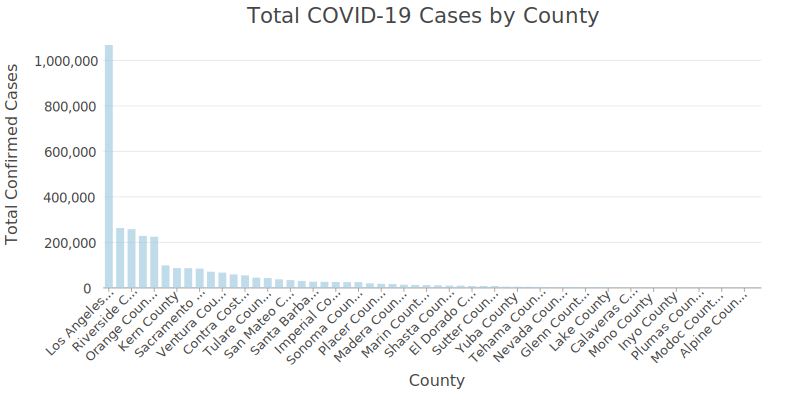

In [33]:
c = arcpy.Chart('covid19_sum_by_county_desc')
c.type = 'bar'
groupTitle = groupField.split('_')[0]
c.title = f"Total COVID-19 Cases by {groupTitle}"
c.xAxis.field = groupField
c.xAxis.title = groupTitle
c.yAxis.field = 'DailyNewConfirmedCases'
c.yAxis.title = "Total Confirmed Cases"
c.yAxis.sort = 'DESC'
c.bar.aggregation = 'sum'
c.displaySize = 800, 400
c.dataSource = table
# c.exportToSVG('covid19_sum_by_county_desc.svg')
c.addToLayer(table) 
c

We can also view aggregated COVID-19 cases over time from a slightly different perspective by creating a <a href="https://pro.arcgis.com/en/pro-app/latest/help/analysis/geoprocessing/charts/calendar-heat-chart.htm" target="_blank">calendar heat chart</a>. <b>This chart aggregates daily new cases of all counties in California and displays them in a calendar grid.</b> The calendar heat chart is effective at showing a per day summary of temporal data, and the color for each cell is determined by a graduated natural breaks scheme.

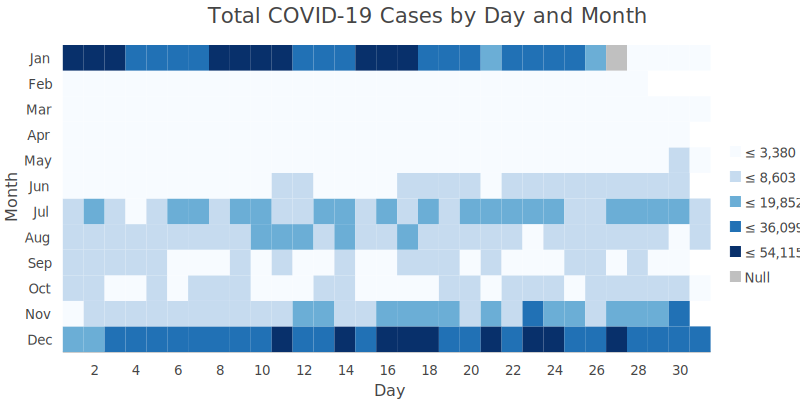

In [34]:
c = arcpy.Chart('covid19_calendar')
c.type = 'calendarHeatChart'
c.title = "Total COVID-19 Cases by Day and Month"
c.xAxis.field = 'DateTime'
c.xAxis.title = "Day"
c.yAxis.field = 'DailyNewConfirmedCases'
c.yAxis.title = "Month"
c.calendarHeatChart.aggregation = 'sum'
c.displaySize = 800, 400
c.dataSource = table
# c.exportToSVG('covid19_calendar.svg')
c.addToLayer(table) 
c

Having visualized the daily new COVID-19 cases aggregated for the entire state, we may also be interested in <b>comparing daily cases between counties within California</b>. 

New in ArcGIS Pro 2.7, we can display this data by creating a <a href="https://pro.arcgis.com/en/pro-app/latest/help/analysis/geoprocessing/charts/matrix-heat-chart.htm#GUID-44D462F3-5E67-46DD-BD1C-862003D2EA5C" target="_blank">matrix heat chart</a> to display each county in a separate row. Matrix heat charts are used to visualize relationships between categorical or date fields with a grid of shaded cells. Here we will view each day on the X-axis by set the chart object's `xAxis.field` property, or Column category in the Chart Properties Pane. To view each county on the Y-axis, and use `DailyNewConfirmedCases` field to determine the intensity of the cell shading, we need to parse a list of the two Field names to the chart object's `yAxis.field` property. Also we can specify the symbology of the cell shading using 7-category Natural Breaks.

In [36]:
c = arcpy.Chart('covid19_daily_by_county')
c.type = 'matrixHeatchart'
c.title = f"Daily COVID-19 Cases by {groupTitle}"
c.xAxis.field = 'DateTime'
c.xAxis.title = 'Day'
c.yAxis.field = [groupField, 'DailyNewConfirmedCases']
c.yAxis.title = groupTitle
c.matrixHeatChart.aggregation = 'sum'
c.matrixHeatChart.classificationMethod = 'naturalBreaks'
c.matrixHeatChart.classCount = 7
c.matrixHeatChart.nullPolicy = 'zero'
c.legend.title = "Number of Cases"
c.displaySize = 800, 1200
c.dataSource = table
# c.exportToSVG('covid19_daily_by_county.svg')
c.addToLayer(table)
c

### Step 8: Time Series Clustering, Forecasting and Identify Outliers
- modulize the analysis using ArcPy to make it easy to reuse
- use 7-day average of daily new cases per 100K residents in all US counties to find various patterns of the disease and make 30-day forecasts
- use ArcPy to customize the symbology based on Forecast Method
- visualize in 2D and 3D

In [10]:
def clustering(inCube, field, outputName, runProfile = True, runFourier = True, runValue= False, numClusters = None, ignore = None, createPopups = True):
    """ Cluster with three Characteristics of Interests together 
    
    Keyword arguments:
    inCube -- Input Space Time Cube with full path (string)
    field -- Cube Variable (string)
    runProfile -- Boolean for using Profile (Correlation) as character of interest (boolean, default = True)
    runFourier -- Boolean for using Profile (Fourier) as character of interest (boolean, default = True)
    runValue -- Boolean for using Value as character of interest (boolean, default = False)
    numClusters -- Number of clusters (int, default = None, auto-detect the optimal # clsuter with min F-stats)
    ignore -- Time Series Characteristics to Ignore, "TIME_LAG"|"RANGE" (string, default = None)
    createPopups -- Boolean for Enable Time Series Pop-ups in output feature (boolean, default = True)
    """
    # Run Profile (Correlation)
    if runProfile:
        outputFc = os.path.join(workGDB, f"{outputName}_TSC_Profile")
        outputChart = os.path.join(workGDB, f"{outputName}_TSC_Profile_Charts")
        arcpy.stpm.TimeSeriesClustering(inCube, field, outputFc, "PROFILE", numClusters, outputChart, None, createPopups)
    # Run Profile (Fourier)
    if runFourier:
        outputFc = os.path.join(workGDB, f"{outputName}_TSC_Fourier")
        outputChart = os.path.join(workGDB, f"{outputName}_TSC_Fourier_Charts")
        arcpy.stpm.TimeSeriesClustering(inCube, field, outputFc, "PROFILE_FOURIER", numClusters, outputChart, ignore, createPopups)
    # Run Profile (Value)
    if runValue:
        outputFc = os.path.join(workGDB, f"{outputName}_TSC_Value")
        outputChart = os.path.join(workGDB, f"{outputName}_TSC_Value_Charts")
        arcpy.stpm.TimeSeriesClustering(inCube, field, outputFc, "VALUE", numClusters, outputChart, None, createPopups)
    return

In [11]:
def forecast(inCube, field, outputName, forecast_time_step, validation_time_step, outlier_identify = "IDENTIFY", outlier_confidence_level = "90%", outlier_max = 1, curve_type = "AUTO_DETECT", season = None, time_window = None, fbf_approach = "VALUE_DETREND", evaluate_use_validation_RMSE = True):
    """ Forecast with Exponenetial Smoothing, Forest-based Forecast, and Curve Fitting, 
    and finally Evaluate the best method with Evaluate Forecast by Location tool
    
    Keyword arguments:
    inCube -- Input Space Time Cube with full path (string)
    field -- Cube Variable (string)
    outputName -- Output Feature name without path, will add suffix for each tool (string)
    forecast_time_step -- Number of Time Steps to Exclude for Validation (int)
    validation_time_step -- Number of Time Steps to Forecast (int)
    outlier_identify -- Outlier Option, "IDENTIFY"|"NONE" (string, default = "IDENTIFY")
    outlier_confidence_level -- Level of Confidence, "90%"|"95%"|"99%" (string, default = "90")
    outlier_max -- Maximum Number of Outliers (int, default = 1)
    
    Parameter for Curve Fit Forecast:
    curve_type -- Curve Type, "AUTO_DETECT"|"LINEAR"|"PARABOLIC"|"EXPONENTIAL"|"GOMPERTZ" (string, default = "AUTO_DETECT")
    
    Parameter for Exponential Smoothing Forecast:
    season -- Season Length (int, default = None, auto detect season length at each location)
    
    Parameter for Forest-based Forecast:
    time_window -- Time Step Window (int, default = None)
                   use min(auto detected season length, 25% total time step) as time window for each location
    fbf_approach -- Forecast Approach, "VALUE"|"VALUE_DETREND"|"RESIDUAL"|"RESIDUAL_DETREND" 
                    (string, default = "VALUE_DETREND")
    
    Parameter for Evaluate Forecasts by Location:
    evaluate_use_validation_RMSE = Boolean for using Validation RMSE to evaluate best method (boolean, default = True)
    """
    # Set output features and cubes
    outputFc0 = os.path.join(workGDB, f"{outputName}_CF")
    outputCube0 = os.path.join(workFolder, f"{outputName}_CF.nc")
    outputFc1 = os.path.join(workGDB, f"{outputName}_ES")
    outputCube1 = os.path.join(workFolder, f"{outputName}_ES.nc")
    outputFc2 = os.path.join(workGDB, f"{outputName}_FBF")
    outputCube2 = os.path.join(workFolder, f"{outputName}_FBF.nc")

    # Run three forecast tools
    arcpy.stpm.CurveFitForecast(inCube, field, outputFc0, outputCube0, forecast_time_step, curve_type, validation_time_step, outlier_identify, outlier_confidence_level, outlier_max)
    arcpy.stpm.ExponentialSmoothingForecast(inCube, field, outputFc1, outputCube1, forecast_time_step, season, validation_time_step, outlier_identify, outlier_confidence_level, outlier_max)
    arcpy.stpm.ForestBasedForecast(inCube, field, outputFc2, outputCube2, forecast_time_step, time_window, validation_time_step, 100, None, None, 100, fbf_approach, outlier_identify, outlier_confidence_level, outlier_max)
    
    # Evaluate results
    cubes = f"{outputCube0};{outputCube1};{outputCube2}"
    outputFc3 = os.path.join(workGDB, f"{outputName}_EFBL")
    outputCube3 = os.path.join(workFolder, f"{outputName}_EFBL.nc")
    arcpy.stpm.EvaluateForecastsByLocation(cubes, outputFc3, outputCube3, evaluate_use_validation_RMSE)
    
    return outputCube0, outputCube1, outputCube2, outputFc3

In [12]:
def viz2D(inCube, field, display_forecast = False, display_outlier = True):
    """ Visualize the Forecast and Outlier results using Visualize Space Time Cube in 2D tool
    
    Keyword arguments:
    inCube -- Input Space Time Cube with full path (string)
    field -- Cube Variable (string)
    display_forecast -- boolean for using Forecast results as Display Theme (boolean, default = False)
    display_outlier -- boolean for using Time series outlier results as Display Theme (boolean, default = True) 
    """
    # Set output features
    cube = os.path.basename(inCube)
    cubeName = cube.split(".")[0]
    outputForecast = os.path.join(workGDB, f"{cubeName}_Viz2D_Forecast")
    outputOutliers = os.path.join(workGDB, f"{cubeName}_Viz2D_Outliers")
    # Display two themes according to user setting
    if display_forecast:
        arcpy.stpm.VisualizeSpaceTimeCube2D(inCube, field, "FORECAST_RESULTS", outputForecast, "CREATE_POPUP")
    if display_outlier:
        arcpy.stpm.VisualizeSpaceTimeCube2D(inCube, field, "TIME_SERIES_OUTLIER_RESULTS", outputOutliers, "CREATE_POPUP")
    return

In [13]:
def viz3D(inCube, field, display_forecast = True, display_outlier = True):
    """ Visualize the Forecast and Outlier results using Visualize Space Time Cube in 3D tool
    
    Keyword arguments:
    inCube -- Input Space Time Cube with full path (string)
    field -- Cube Variable (string)
    display_forecast -- boolean for using Forecast results as Display Theme (boolean, default = True)
    display_outlier -- boolean for using Time series outlier results as Display Theme (boolean, default = True) 
    """
    # Set output features
    cube = os.path.basename(inCube)
    cubeName = cube.split(".")[0]
    outputForecast = os.path.join(workGDB, f"{cubeName}_Viz3D_Forecast")
    outputOutliers = os.path.join(workGDB, f"{cubeName}_Viz3D_Outliers")
    # Display two themes according to user setting
    if display_forecast:
        arcpy.stpm.VisualizeSpaceTimeCube3D(inCube, field, "FORECAST_RESULTS", outputForecast)
    if display_outlier:
        arcpy.stpm.VisualizeSpaceTimeCube3D(inCube, field, "TIME_SERIES_OUTLIER_RESULTS", outputOutliers)
    return

In [14]:
# Reference: 
# [unique value renderer] https://pro.arcgis.com/en/pro-app/latest/arcpy/mapping/uniquevaluerenderer-class.htm
# [symbol] https://pro.arcgis.com/en/pro-app/latest/arcpy/mapping/symbol-class.htm

def symbolWithForecastMethod(layer):
    """ Change the symbology of Evaluate Forecasts by Location tool's output feature using Forecast Method field 
    exponential smoothing --> purple
    forest-based forecast --> blue
    four types of curve --> red to yellow color scheme
    
    Keyword arguments:
    layer -- the name of the layer without path
    """
    
    # Get the layer object by the layer name
    aprx = arcpy.mp.ArcGISProject('CURRENT')
    m = aprx.listMaps('*')[0]
    l = m.listLayers(layer)[0]
    
    # Get the symbology of the layer, set to Unique Value Renderer on the METHOD field
    sym = l.symbology
    sym.updateRenderer('UniqueValueRenderer')
    sym.renderer.fields = ['METHOD']
    
    for grp in sym.renderer.groups:
        for itm in grp.items:
            forecastMethod = itm.values[0][0] #Grab the first "percent" value in the list of potential values
            print(forecastMethod)

            # set Outline color
            itm.symbol.outlineColor  = {'RGB': [204, 204, 204, 100]} #light grey

            # set color based on best Forecast Method
            if "exponential smoothing" in forecastMethod:
                itm.symbol.color = {'RGB': [49, 162, 189, 100]} #blue
                itm.label = "exponential smoothing"
            elif "forest-based" in forecastMethod:
                itm.symbol.color = {'RGB': [126, 87, 194, 100]} #purple
                itm.label = "forest-based"
            elif forecastMethod == "gompertz":
                itm.symbol.color = {'RGB': [242, 103, 69, 100]} #red
                itm.label = "gompertz"
            elif forecastMethod == "parabolic":
                itm.symbol.color = {'RGB': [244, 147, 104, 100]} #dark orange
                itm.label = "parabolic"
            elif forecastMethod == "exponential":
                itm.symbol.color = {'RGB': [250, 165, 19, 100]} #light orange
                itm.label = "exponential"
            elif forecastMethod == "linear":
                itm.symbol.color = {'RGB': [255, 199, 0, 100]} #yellow
                itm.label = "linear"
            else:
                itm.symbol.color = {'RGB': [204, 204, 204, 100]} #grey
                itm.label = "mean"

    l.symbology = sym
    return

In [15]:
# Clustering and forecasting for following 4 weeks with weekly new cases in US (Curve Fit 6 minutes)
# The TSC (Fourier) and Forecast Method Map is very interesting
cube = f"confirmed_and_death_{date}.nc"
field = "DAILYNEWCONFIRMEDCASES_7DAYAVERAGE_PER100K"
outputName = f"US_7dayAvgDailyCasesPer100K_thru_{date}"

inCube = os.path.join(workFolder, cube)
forecast_time_step = 30
validation_time_step = 30
outlier_identify = "Identify"
outlier_confidence_level = "95%"
outlier_max = 5
boolean_validation_RMSE = True

# Clustering
clustering(inCube, field, outputName)
# Forecast with three different methods and evaluate by Validation RMSE
cubeCF, cubeES, cubeFBF, fcEFBL = forecast(inCube, field, outputName, forecast_time_step, validation_time_step, outlier_identify, evaluate_use_validation_RMSE = boolean_validation_RMSE)

In [16]:
# Change the symbology of EFBL tool's output using Forecast Method
output = os.path.basename(fcEFBL)
symbolWithForecastMethod(output)

exponential
exponential smoothing; seasonality:auto_detect
forest-based; seed:96635; number_of_trees:100; sample_size:100; forecast_approach:value_detrend; outlier_option:identify; level_of_confidence:90%; maximum_number_of_outliers:1; time_window:auto_detect
gompertz
linear
mean
parabolic


In [23]:
# Visualize Outlier result in 2D: number of outliers at each county
viz2D(cubeES, field)
# Visualize Outlier result in 3D: check the Count of Outliers Above and Below Fitted Value Over Time
viz3D(cubeES, field, display_forecast = False, display_outlier = True)

#### Analysis 1: use 7-day average daily cases per 100K in California to find various patterns of the disease and make 30-day forecasts

In [16]:
# Clustering and forecasting for 30 days with DAILYNEWCONFIRMEDCASES_7DAYAVERAGE_PER100K in California
cube = f"confirmed_and_death_CA_thru_{date}.nc"
field = "DAILYNEWCONFIRMEDCASES_7DAYAVERAGE_PER100K"
outputName = f"CA_{field}_thru_{date}"

inCube = os.path.join(workFolder, cube)
forecast_time_step = 30
validation_time_step = 30
outlier_identify = None
boolean_validation_RMSE = True

# Clustering
clustering(inCube, field, outputName)
# Forecast with three different methods and evaluate by Validation RMSE
cubeCF, cubeES, cubeFBF, fcEFBL = forecast(inCube, field, outputName, forecast_time_step, validation_time_step, outlier_identify, evaluate_use_validation_RMSE = boolean_validation_RMSE)

#### Analysis 2: use raw data of daily cases per 100K in Florida for identify outliers and use visualize 2D/3D tool to understand results

In [24]:
# Identify outliers with DAILYNEWCONFIRMEDCASES_PER100K in Florida
cube = f"confirmed_and_death_FL_thru_{date}.nc"
field = "DAILYNEWCONFIRMEDCASES_PER100K"
outputName = f"FL_{field}_thru_{date}"

inCube = os.path.join(workFolder, cube)
forecast_time_step = 30
validation_time_step = 30
outlier_identify = "Identify"
outlier_confidence_level = "95%"
outlier_max = 5

# Identify outliers
cubeCF, cubeES, cubeFBF, fcEFBL = forecast(inCube, field, outputName, forecast_time_step, validation_time_step, outlier_identify, outlier_confidence_level, outlier_max, evaluate_use_validation_RMSE = False)
# Visualize Outlier result in 2D: number of outliers at each county
viz2D(cubeES, field)
# Visualize Outlier result in 3D: check the Count of Outliers Above and Below Fitted Value Over Time
viz3D(cubeES, field, display_forecast = False, display_outlier = True)

#### Analysis 3: use weekly new cases in all US counties to find various patterns and make 4-week forecast

In [20]:
# Clustering and forecasting for following 4 weeks with weekly new cases in US (Curve Fit 6 minutes)
# The TSC (Fourier) and Forecast Method Map is very interesting
cube = f"confirmed_and_death_{date}_1week.nc"
field = "DAILYNEWCONFIRMEDCASES_SUM_NONE"
outputName = f"US_WeeklyCases_thru_{date}"

inCube = os.path.join(workFolder, cube)
forecast_time_step = 4
validation_time_step = 4
outlier_identify = None
boolean_validation_RMSE = True

# Clustering
clustering(inCube, field, outputName)
# Forecast with three different methods and evaluate by Validation RMSE
cubeCF, cubeES, cubeFBF, fcEFBL = forecast(inCube, field, outputName, forecast_time_step, validation_time_step, outlier_identify, evaluate_use_validation_RMSE = boolean_validation_RMSE)
# Change the symbology of EFBL tool's output using Forecast Method
output = os.path.basename(fcEFBL)
symbolWithForecastMethod(output)

exponential
exponential smoothing; seasonality:auto_detect
forest-based; seed:43256; number_of_trees:100; sample_size:100; forecast_approach:value_detrend; outlier_option:none; level_of_confidence:90%; maximum_number_of_outliers:1; time_window:auto_detect
gompertz
linear
parabolic
